"""
Generate data with specified changepoints
Compare ELBO fits for changepoint model with different
numbers of changepoints
"""

In [2]:
#https://discourse.pymc.io/t/nuts-uses-all-cores/909/9


import os
os.environ["MKL_NUM_THREADS"]='1'
os.environ["OMP_NUM_THREADS"]='1'

In [3]:
import pickle
import scipy.stats as stats
import pymc3 as pm
import theano.tensor as tt
import numpy as np
import pylab as plt
from pymc3.variational.callbacks import CheckParametersConvergence
from theano.tensor.extra_ops import cumsum
import arviz as az
import pandas as pd
import seaborn as sns

In [4]:
# np.__config__.show()

In [5]:
def stick_breaking(beta):
    portion_remaining = tt.concatenate([[1], tt.extra_ops.cumprod(1 - beta)[:-1]])
    return beta * portion_remaining

[41]
[  0  41 200]
(5, 2)
(5, 200)


Text(0, 0.5, 'Neuron # (Channels)')

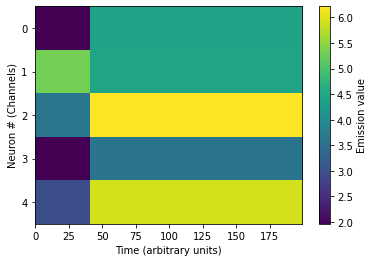

In [153]:
# Some poisson spiking
length = 200
states = 2
fit = int(1e5)
samples = 2000
idx = np.arange(length)

true_tau = np.cumsum(np.random.random(states))
true_tau /= np.max(true_tau)
true_tau *= length
true_tau = np.vectorize(np.int)(true_tau)
state_inds = np.concatenate([np.zeros((1)),true_tau])
state_inds = np.vectorize(np.int)(state_inds)
true_tau = true_tau[:-1]

nrns = 5
lambda_multipliers = np.random.random(states) * 10
true_lambda = np.random.random((nrns,states))
true_lambda = true_lambda * lambda_multipliers[np.newaxis,:]

print(true_tau)
print(state_inds)
print(true_lambda.shape)

true_r = np.zeros((nrns,length))
print(true_r.shape)
for num, val in enumerate(true_lambda.T):
    true_r[:,state_inds[num]:state_inds[num+1]] = val[:,np.newaxis]
  
plt.imshow(true_r,aspect='auto', interpolation='nearest');plt.colorbar(label = 'Emission value')
plt.xlabel('Time (arbitrary units)')
plt.ylabel("Neuron # (Channels)")

In [207]:
# Max number of states
changes = 10

with pm.Model() as dpp_model:
    
    # =====================
    # Changepoint Variables
    # =====================
    
    # Hyperpriors on alpha
    a_gamma = pm.Gamma('a_gamma',2,1)
    b_gamma = pm.Gamma('b_gamma',1.5,1)
    
    # Concentration parameter for beta
    alpha = pm.Gamma('alpha', a_gamma, b_gamma)
    
    # Draw beta's to calculate stick lengths
    beta = pm.Beta('beta', 1, alpha, shape = changes)
    
    # Calculate stick lengths using stick_breaking process
    w_raw = pm.Deterministic('w_raw', stick_breaking(beta))
    
    # Make sure lengths add to 1, and scale to length of data
    w_latent = pm.Deterministic('w_latent', w_raw / w_raw.sum())
    tau = pm.Deterministic('tau', tt.cumsum(w_latent * length)[:-1])
    
    # Weight stack to assign lambda's to point in time
    weight_stack = tt.nnet.sigmoid(idx[np.newaxis,:]-tau[:,np.newaxis])
    weight_stack = tt.concatenate([np.ones((1,length)),weight_stack],axis=0)
    inverse_stack = 1 - weight_stack[1:]
    inverse_stack = tt.concatenate([inverse_stack, np.ones((1,length))],axis=0)
    weight_stack = np.multiply(weight_stack,inverse_stack)
    
    # =====================
    # Projection Matrix
    # =====================
    # Data = neurons x time
    # Template = dims x time
    # Projection mat = neurons x dims
    proj_mat = pm.Normal('proj_mat', mu = 0, sigma = 10, shape = (nrns, changes))
    
    projected_dat = pm.Deterministic('proj_dat', tt.dot(proj_mat,weight_stack))
    
    # =====================
    # Likelihood
    # =====================
    obs = pm.Normal('obs', mu = projected_dat, sigma = 10, observed = true_r)

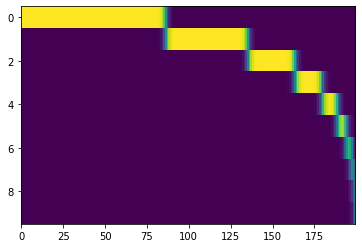

In [208]:
plt.imshow(weight_stack.tag.test_value, aspect='auto', interpolation='nearest')

In [209]:
with dpp_model:
    spp = pm.sample_prior_predictive(samples = 5000)

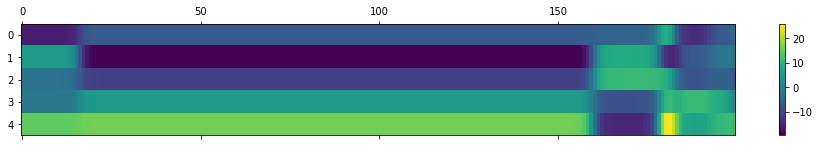

In [210]:
plt.matshow(spp['proj_dat'][0], aspect='auto');plt.colorbar()

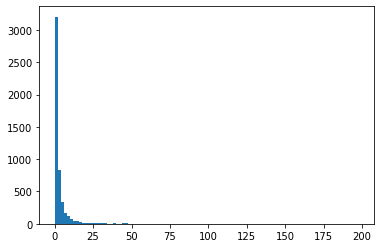

In [211]:
plt.hist(spp['alpha'],bins = np.arange(0,200,2));

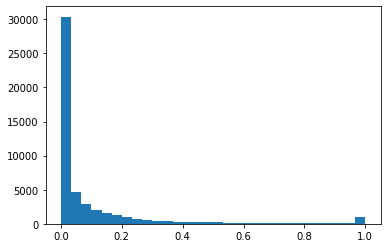

In [212]:
plt.hist(spp['w_latent'].flatten(), bins = 30);

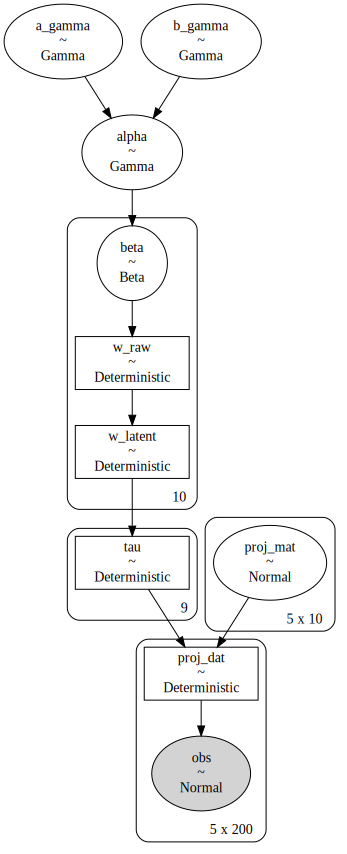

In [213]:
pm.model_to_graphviz(dpp_model)

In [214]:
with dpp_model:
    # dpp_trace = pm.sample()
    dpp_trace = pm.sample(
                        tune = 500,
                        draws = 500, 
                          target_accept = 0.95,
                         chains = 24,
                         cores = 24,
                        return_inferencedata=False)
    
    #dpp_trace = pm.sample_smc(parallel = False)
    
#     inference = pm.ADVI('full-rank')
#     approx = pm.fit(n=160000, method=inference)
#     dpp_trace = approx.sample(draws=2000)
#     hist = -approx.hist[-50000:]
#     plt.plot(hist)
#     box_kern = np.ones(500)/500
#     plt.plot(np.convolve(hist,box_kern, mode='valid'))

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (24 chains in 24 jobs)
NUTS: [proj_mat, beta, alpha, b_gamma, a_gamma]


Sampling 24 chains for 500 tune and 500 draw iterations (12_000 + 12_000 draws total) took 24 seconds.
There were 165 divergences after tuning. Increase `target_accept` or reparameterize.
There were 97 divergences after tuning. Increase `target_accept` or reparameterize.
There were 114 divergences after tuning. Increase `target_accept` or reparameterize.
There were 134 divergences after tuning. Increase `target_accept` or reparameterize.
There were 106 divergences after tuning. Increase `target_accept` or reparameterize.
There were 126 divergences after tuning. Increase `target_accept` or reparameterize.
There were 111 divergences after tuning. Increase `target_accept` or reparameterize.
There were 137 divergences after tuning. Increase `target_accept` or reparameterize.
There were 138 divergences after tuning. Increase `target_accept` or reparameterize.
There were 146 divergences after tuning. Increase `target_accept` or reparameterize.
There were 148 divergences after tuning. Increas

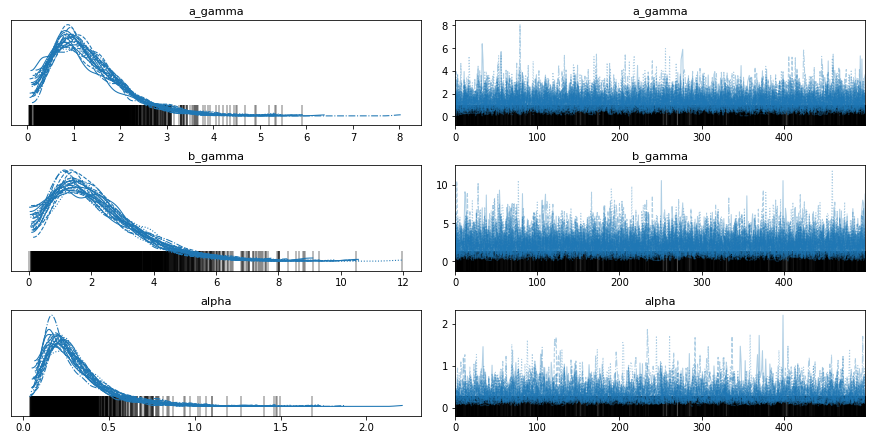

In [215]:
with dpp_model:
    pm.traceplot(dpp_trace, var_names = ['a_gamma','b_gamma','alpha']);

/home/abuzarmahmood/anaconda3/lib/python3.6/site-packages/arviz/plots/pairplot.py:228: UserWarning: Divergences data not found, plotting without divergences. Make sure the sample method provides divergences data and that it is present in the `diverging` field of `sample_stats` or `sample_stats_prior` or set divergences=False
  UserWarning,


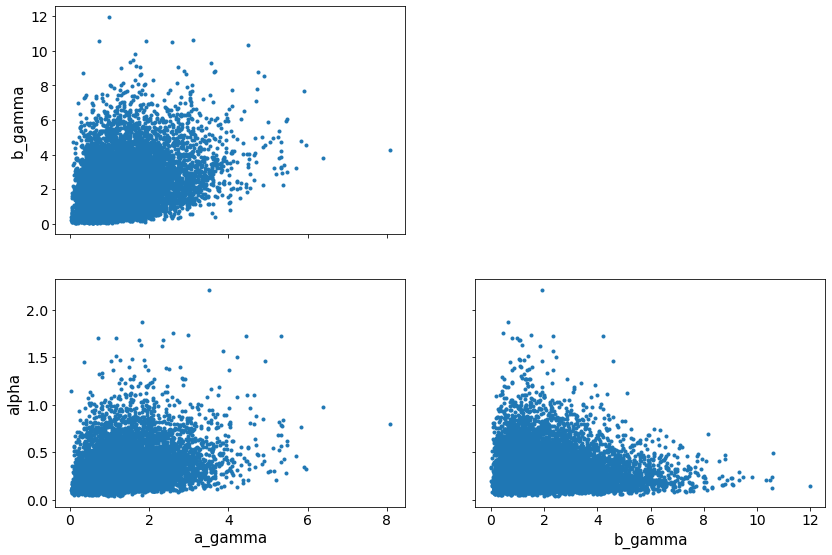

In [216]:
with dpp_model:
    pm.pairplot(dpp_trace, var_names = ['a_gamma','b_gamma','alpha'], divergences = True);

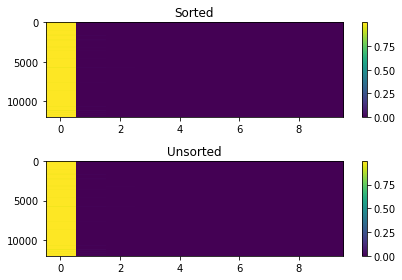

In [217]:
#sorted_lens = np.sort(dpp_trace['w_latent'],axis=-1)[:,::-1]
#w_latent_samples = dpp_trace.posterior.data_vars['w_latent'].values
w_latent_samples = dpp_trace['w_latent']
#cat_w_latent_samples = np.concatenate(w_latent_samples)
cat_w_latent_samples = w_latent_samples
sorted_lens = np.sort(cat_w_latent_samples,axis=-1)[:,::-1]
mean_lens = sorted_lens.mean(axis=0)
std_lens = sorted_lens.std(axis=0)

fig,ax = plt.subplots(2,1)
im1 = ax[0].imshow(sorted_lens, interpolation='nearest', aspect= 'auto')
im2 = ax[1].imshow(cat_w_latent_samples, interpolation='nearest', aspect= 'auto')
fig.colorbar(im1, ax=ax[0])
fig.colorbar(im2, ax=ax[1])
ax[0].set_title('Sorted')
ax[1].set_title('Unsorted')
plt.tight_layout()

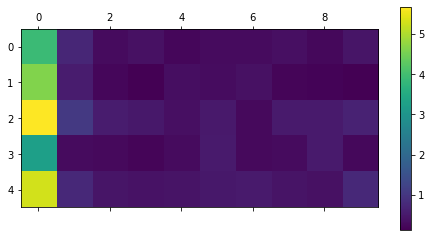

In [218]:
plt.matshow(dpp_trace['proj_mat'].mean(axis=0)); plt.colorbar()

In [219]:
with dpp_model:
    ppc = pm.sample_posterior_predictive(dpp_trace,samples = 5000)

/home/abuzarmahmood/anaconda3/lib/python3.6/site-packages/pymc3/sampling.py:1708: UserWarning: samples parameter is smaller than nchains times ndraws, some draws and/or chains may not be represented in the returned posterior predictive sample
  "samples parameter is smaller than nchains times ndraws, some draws "


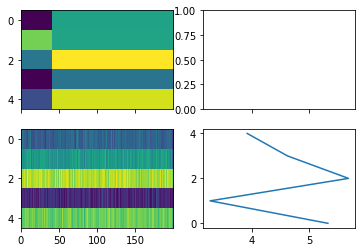

In [220]:
fig,ax = plt.subplots(2,2, sharex='col')
ax[0,0].imshow(true_r, interpolation = 'nearest', aspect='auto')
ax[1,0].imshow(ppc['obs'].mean(axis=0), interpolation = 'nearest', aspect='auto')
ax[1,1].plot(true_r.mean(axis=-1)[::-1], np.arange(len(true_r)))

In [221]:
sorted_w_latent = np.stack(np.array_split(np.sort(w_latent_samples,axis=-1)[...,::-1],16,axis=0))
mean_sorted = np.mean(sorted_w_latent, axis = 1)

all_state_edges = np.concatenate([[0],true_tau,[length]])
state_durations = np.abs(np.diff(all_state_edges))
sorted_state_durations = np.sort(state_durations / length)[::-1]
shortest_state = sorted_state_durations[-1]

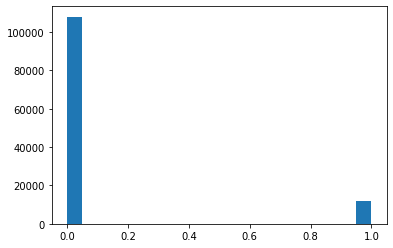

In [222]:
plt.hist(sorted_lens.flatten(), bins = 20);

<BarContainer object of 2 artists>

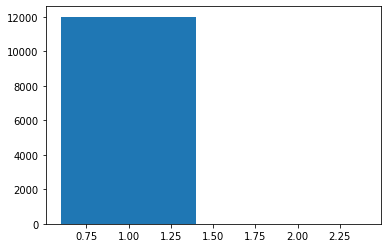

In [223]:
counts = (sorted_lens > 0.1).sum(axis=-1)
count_dict = list(zip(*[(x,sum(counts==x)) for x in np.unique(counts)]))
plt.bar(*count_dict)